In [1]:
"""imports"""
import os
from ansys.edb.database import Database
from ansys.edb.session import launch_session
import ansys.edb as edb
import json
import subprocess
import psutil
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib import colors as mcolors
from matplotlib.collections import PatchCollection

In [3]:
"""configs"""
ROOT = os.getcwd()
EXE_ROOT = os.environ['ANSYSEM_ROOT232']
ROOT = os.getcwd()
EDB_FILE = os.path.join(ROOT,'data','meshed_ground.aedb')
# EDB_FILE = r'D:\2023\SAMSUNG\One_Click_CIS_Automation_main\5_4HB_FF_Vertical_211111\5_4HB_FF_Vertical_211111.aedb'
out = os.path.join(ROOT,'data','stackup_export.aedb')
json_file = os.path.join(ROOT,'data','net_polygon_export.json')
python_script =os.path.join(ROOT,'plot_edb.py')
image_file = os.path.join(ROOT,'data','out.png')
    

In [4]:
"""launch session"""
PROCNAME = "EDB_RPC_Server.exe"
try:
    for proc in psutil.process_iter():
        if proc.name() == PROCNAME:
            proc.kill()
except:
    pass
session = launch_session(EXE_ROOT, 50051)

In [5]:
"""open db"""
db = Database.open(EDB_FILE,False)
cell = db.circuit_cells[0]
layout = cell.layout
layerStats = []
lc = layout.layer_collection
layers = lc.get_layers()
layer_names = [i.name for i in layers]

In [6]:
def eval_arc_points(p1, p2, h, n=6, tol=1e-12):
    import math
    # fmt: off
    if abs(h) < tol:
        return [], []
    elif h > 0:
        reverse = False
        x1 = p1[0]
        y1 = p1[1]
        x2 = p2[0]
        y2 = p2[1]
    else:
        reverse = True
        x1 = p2[0]
        y1 = p2[1]
        x2 = p1[0]
        y2 = p1[1]
        h *= -1
    xa = (x2-x1) / 2
    ya = (y2-y1) / 2
    xo = x1 + xa
    yo = y1 + ya
    a = math.sqrt(xa**2 + ya**2)
    if a < tol:
        return [], []
    r = (a**2)/(2*h) + h/2
    if abs(r-a) < tol:
        b = 0
        th = 2 * math.asin(1)  # chord angle
    else:
        b = math.sqrt(r**2 - a**2)
        th = 2 * math.asin(a/r)  # chord angle

    # center of the circle
    xc = xo + b*ya/a
    yc = yo - b*xa/a

    alpha = math.atan2((y1-yc), (x1-xc))
    xr = []
    yr = []
    for i in range(n):
        i += 1
        dth = (i/(n+1)) * th
        xi = xc + r * math.cos(alpha-dth)
        yi = yc + r * math.sin(alpha-dth)
        xr.append(xi)
        yr.append(yi)

    if reverse:
        xr.reverse()
        yr.reverse()
    # fmt: on
    return xr, yr

C:\Users\louseph\AppData\Local\Temp\ipykernel_20620\2202416059.py:65: MatplotlibDeprecationWarning: Passing the closed parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  pp = Polygon(P,True)


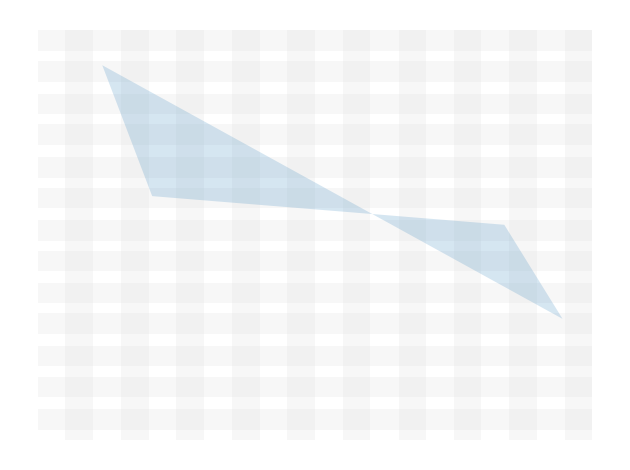

In [18]:
nets = layout.nets
Poly={}
selected_nets=[]
selected_layers = []
Poly['voids'] = {}
for net in nets:
    netName = net.name
    if netName in selected_nets or len(selected_nets)==0:
        prims = list(net.primitives)
        Poly[netName] = {}
        for c,prim in enumerate(prims):
            # print(c)
            if prim.layer.name in selected_layers or len(selected_layers)==0:
                if prim.primitive_type.value==3:
                    width = prim.width.value
                    polygonData = prim.center_line.points
                elif prim.primitive_type.value==2:
                    width = 0
                    polygonData = prim.polygon_data.points
                elif prim.primitive_type.value==1:
                    width = 0
                    polygonData = prim.owner.polygon_data.points
                else:
                    pass
                
                xy = [[float(i.x.value),float(i.y.value)] for i in polygonData]
                Poly[netName]['{}'.format(c)] = [xy,width]
                if prim.has_voids:
                    for void in prim.voids:
                        polygonData = void.get_polygon_data().points
                        xy = [[float(i.x.value),float(i.y.value)] for i in polygonData]
                        width=0
                        Poly['voids']['{}'.format(len(Poly['voids']))] = [xy,width]
                

dpi = '60'
ii = [float(j) for key in Poly for i in Poly[key] for k in Poly[key][i][0] if len(k)>1 for j in k]
xmin = min(ii[0::2]);xmax = max(ii[0::2])
ymin = min(ii[1::2]);ymax = max(ii[1::2])

scale = 1e3
cm = (1/2.54)
W = abs(xmin-xmax)*cm*scale
H = abs(ymin-ymax)*cm*scale

key = list(Poly.keys())
fig, ax = plt.subplots(frameon=False,dpi=None)

golden_ratio_conjugate = 0.618033988749895
nn,alpha=18,.6

c=[];patches = [];h = .2;x=[];y=[]
for key1 in Poly:
    if key1 == 'voids':
        continue
    h += golden_ratio_conjugate
    h %= 1
    net_color = h
    for key2 in Poly[key1]:
        c.append(net_color)
        P = Poly[key1][key2][0]
        P = [i for i in P if len(i)>1 if max(i)<100]
        # if max(P)>1e3:
        #     continue
        pp = Polygon(P,True)
        patches.append(pp)
name = ['turbo','nipy_spectral','gist_ncar','cubehelix','brg','gist_rainbow', 'rainbow', 'jet','flag', 'prism', 'ocean', 'gist_earth', 'terrain','flag', 'prism', 'ocean', 'gist_earth', 'terrain','tab20c','Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2','Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2','RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic','Wistia', 'hot', 'afmhot', 'gist_heat', 'copper''Wistia', 'hot', 'afmhot', 'gist_heat', 'copper','binary', 'gist_yarg', 'gist_gray', 'gray', 'bone','binary', 'gist_yarg', 'gist_gray', 'gray', 'bone','GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu','Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','viridis', 'plasma', 'inferno', 'magma', 'cividis']
cmap = name[nn]
collection = PatchCollection(patches, cmap=matplotlib.colormaps[cmap], alpha=alpha,linewidths=(0,))
collection.set_array(c)
collection.set_linewidth(0)
collection.set_alpha(.2)
ax.add_collection(collection)
plt.xlim((xmin,xmax))
plt.ylim((ymin,ymax))
ax.set_axis_off()
ax.autoscale(enable=True)
# plt.gcf().set_size_inches(W, H)
plt.tight_layout()
plt.show()
# plt.savefig(image_file,bbox_inches='tight',dpi=dpi,transparent=True)

In [ ]:
"""End the session"""
session.disconnect()